In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

import os
import numpy as np
import pandas as pd

TF version: 2.7.0
TF Hub version: 0.12.0
GPU available (YESSSS!!!!!)


## Data

In [2]:
# Checkout the labels of our data
labels_csv = pd.read_csv("data/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<AxesSubplot:>

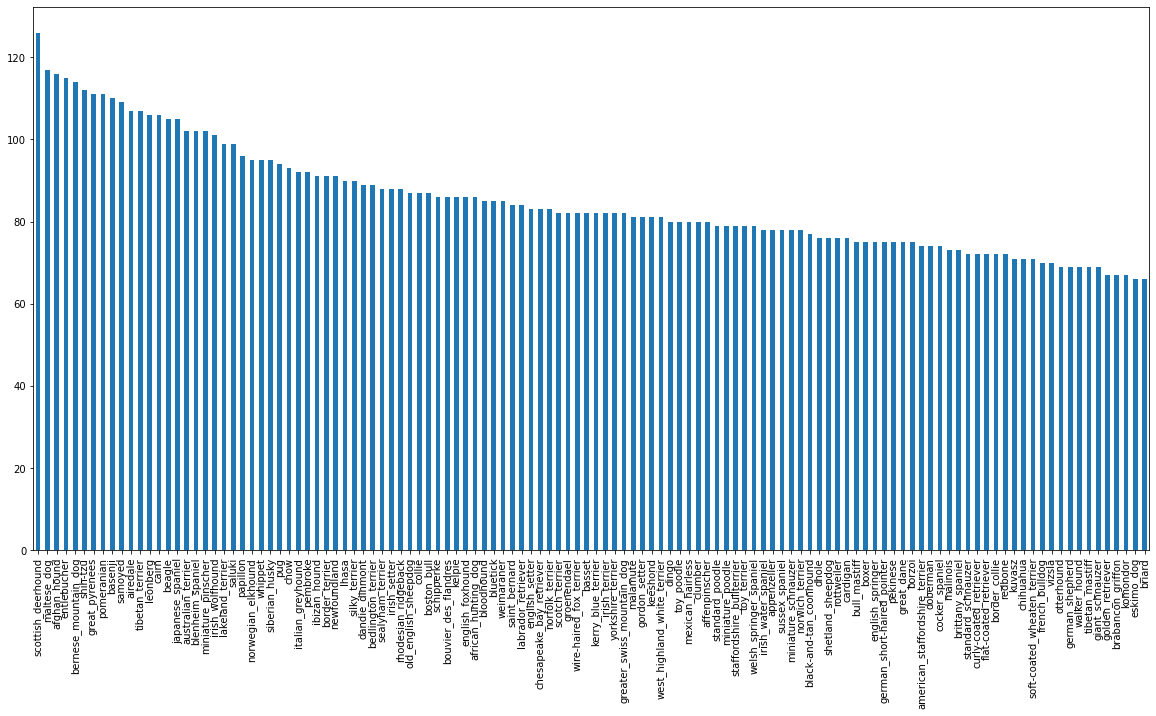

In [3]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20, 10))

In [4]:
# Create pathnames from image ID's
filenames = ["data/Dog Vision/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['data/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [5]:
labels = labels_csv["breed"].to_numpy() # labels = np.array(labels) # does same thing as above
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [6]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [54]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

In [8]:
# Setup X & y variables
X = filenames
y = boolean_labels

### Split into train & validation test

In [9]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

NUM_IMAGES = 1000

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [10]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [11]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

Creating training data batches...
Creating validation data batches...


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualization data

In [12]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image 
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

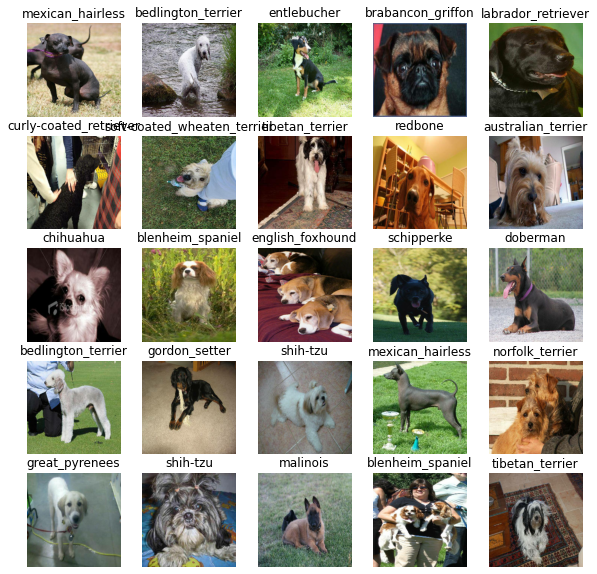

In [13]:
# Now let's visualize the data in a training batch
train_images, train_labels = train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

## Building a model

In [14]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [15]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

In [16]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [17]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("data/Dog Vision/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [18]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

In [19]:
NUM_EPOCHS = 100 

In [20]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [21]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 34s 322ms/step - loss: 4.5991 - accuracy: 0.0900 - val_loss: 3.4363 - val_accuracy: 0.2350
Epoch 2/100
25/25 [==============================] - 4s 175ms/step - loss: 1.6373 - accuracy: 0.6825 - val_loss: 2.1870 - val_accuracy: 0.5150
Epoch 3/100
25/25 [==============================] - 7s 174ms/step - loss: 0.5569 - accuracy: 0.9425 - val_loss: 1.6988 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 4s 172ms/step - loss: 0.2562 - accuracy: 0.9850 - val_loss: 1.5326 - val_accuracy: 0.6200
Epoch 5/100
25/25 [==============================] - 4s 173ms/step - loss: 0.1451 - accuracy: 0.9987 - val_loss: 1.4571 - val_accuracy: 0.6400
Epoch 6/100
25/25 [==============================] - 7s 295ms/step - loss: 0.1004 - accuracy: 0.9987 - val_loss: 1.4135 - val_accuracy: 0.6450
Epoch 7/100
25/25 [=============================

In [33]:
#Checking the TensorBoard logs
#%tensorboard --logdir data/Dog Vision/logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Miniconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Miniconda3\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorboard\main.py", line 42, in run_main
    plugins=default.get_plugins(),
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorboard\default.py", line 105, in get_plugins
    return get_static_plugins() + get_dynamic_plugins()
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorboard\default.py", line 140, in get_dynamic_plugins
    return [
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorboard\default.py", line 141, in <listcomp>
    entry_point.resolve()
  File "C:\ProgramData\Miniconda3\

## Model Evaluation

In [23]:
# Evaluate the pre-saved model
model.evaluate(val_data)

7/7 [==============================] - 0s 35ms/step - loss: 1.3360 - accuracy: 0.6500


[1.3360356092453003, 0.6499999761581421]

In [24]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)

# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

7/7 [==============================] - 1s 33ms/step


In [25]:
# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'brittany_spaniel'

In [53]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)

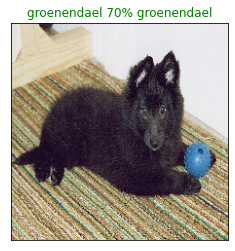

In [27]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,
          n=77)

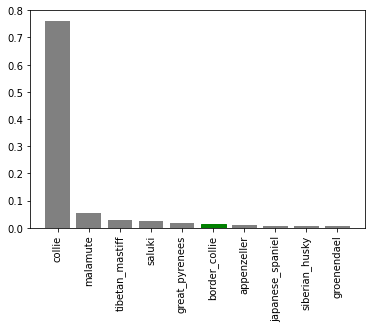

In [28]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=9)

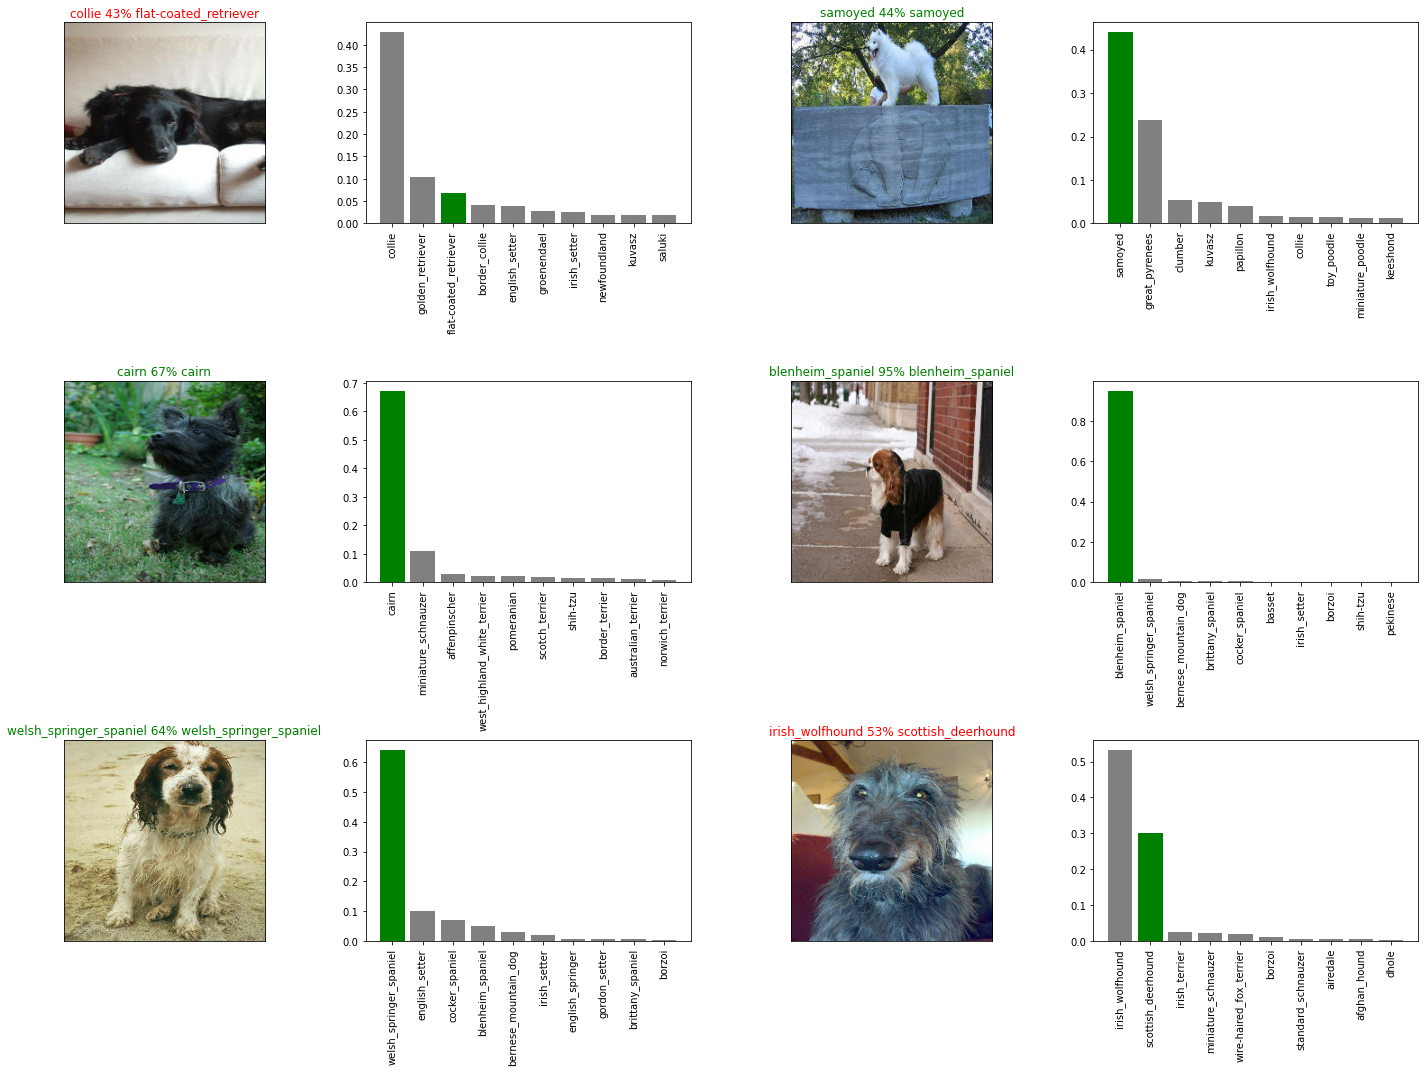

In [29]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving and reloading a trained model

In [39]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("data/Dog Vision/models",
                          )#datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
  model_path = modeldir + "-" + suffix + ".h5py" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [40]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenetv2-Adam")

Saving model to: data/Dog Vision/models-1000-images-mobilenetv2-Adam.h5py...
INFO:tensorflow:Assets written to: data/Dog Vision/models-1000-images-mobilenetv2-Adam.h5py\assets


INFO:tensorflow:Assets written to: data/Dog Vision/models-1000-images-mobilenetv2-Adam.h5py\assets


'data/Dog Vision/models-1000-images-mobilenetv2-Adam.h5py'

In [42]:
# Load a trained model
loaded_1000_image_model = load_model('data/Dog Vision/models-1000-images-mobilenetv2-Adam.h5py')

Loading saved model from: data/Dog Vision/models-1000-images-mobilenetv2-Adam.h5py


In [43]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 4s 519ms/step - loss: 1.3360 - accuracy: 0.6500


[1.3360356092453003, 0.6499999761581421]

## Making predictions on the test dataset

In [44]:
# Load test image filenames
test_path = "data/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['data/Dog Vision/test/000621fb3cbb32d8935728e48679680e.jpg',
 'data/Dog Vision/test/00102ee9d8eb90812350685311fe5890.jpg',
 'data/Dog Vision/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'data/Dog Vision/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'data/Dog Vision/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'data/Dog Vision/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'data/Dog Vision/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'data/Dog Vision/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'data/Dog Vision/test/002f80396f1e3db687c5932d7978b196.jpg',
 'data/Dog Vision/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [45]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [47]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_1000_image_model.predict(test_data,verbose=1)

37/37 [==============================] - 8s 208ms/step


In [49]:
# Save predictions (NumPy array) to csv file (for access later)
np.savetxt("data/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

# Load predictions (NumPy array) from csv file
#test_predictions = np.loadtxt("data/Dog Vision/preds_array.csv", delimiter=",")